# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [2]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            # hidden layer 1
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            # hidden layer 2
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            # hidden layer 3
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            # output layer
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE
    X_train_scaled, y_train, X_test_scaled, y_test = split_dataset(df, columns_to_drop=["filename", "label"], test_size=0.3, random_state=0)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train_scaled, X_test_scaled)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

In [4]:
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

print(df['label'].value_counts())

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

label
pos    6202
neg    5855
Name: count, dtype: int64


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [5]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = self.X[idx]
        label = self.y[idx]
        return x, label


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)
    
    return train_dataloader, test_dataloader

In [6]:
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [7]:
# YOUR CODE HERE
# Hyperparameters
drop_out = 0.2
no_features = 77 # 77 from number of features in the dataset
no_hidden = 128
no_labels = 1 # label = positive or negative emotions, so 1. (aim is to determine the speech polarity of the engineered)
lr = 0.001

model = MLP(no_features=no_features, no_hidden=no_hidden, no_labels=no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [8]:
def train_loop(train_dataloader, model, loss_fn, optimizer):
    # Initialize variables to track loss and accuracy
    train_loss, correct = 0, 0
    num_batches = len(train_dataloader)

    for batch, (X, y) in enumerate(train_dataloader):
        # Forward pass: Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Compute accuracy
        correct += (pred.round() == y).type(torch.float).sum().item()
        train_loss += loss.item()

        # Backpropagation: Clear gradients, compute gradients, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")

    # Calculate average loss and accuracy
    train_loss /= num_batches
    correct /= len(train_dataloader.dataset)
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    return train_loss, correct

def test_loop(test_dataloader, model, loss_fn):
    # Initialize variables to track loss and accuracy
    test_loss, correct = 0, 0
    num_batches = len(test_dataloader)

    with torch.no_grad():
        for X, y in test_dataloader:
            # Forward pass: Compute prediction
            pred = model(X)

            # Compute test loss
            test_loss += loss_fn(pred, y).item()

            # Compute accuracy
            correct += (pred.round() == y).type(torch.float).sum().item()

    # Calculate average loss and accuracy
    test_loss /= num_batches
    correct /= len(test_dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

In [12]:
# Define hyperparameters
patience = 3  # Patience for early stopping
num_epochs = 100  # Number of training epochs
learning_rate = 0.001  # Learning rate

# Initialize EarlyStopper for early stopping
from common_utils import EarlyStopper
early_stopper = EarlyStopper(patience=patience, min_delta=0)

# Lists to track training and testing loss, accuracy
train_loss, test_loss = [], []
train_acc, test_acc = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    # Training loop: Compute training loss and accuracy
    loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss)
    train_acc.append(acc)

    # Testing loop: Compute testing loss and accuracy
    loss, acc = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(loss)
    test_acc.append(acc)

    # Check for early stopping
    if early_stopper.early_stop(loss):
        print("Early stop detected!")
        break

print("Training completed!")  # Indicate the end of training

Epoch 1
-------------------------------
loss: 0.697151  [  256/ 8439]
loss: 0.686059  [ 2816/ 8439]
loss: 0.687299  [ 5376/ 8439]
loss: 0.670696  [ 7936/ 8439]
Train Error: 
 Accuracy: 53.5%, Avg loss: 0.687970 

Test Error: 
 Accuracy: 56.4%, Avg loss: 0.684445 

Epoch 2
-------------------------------
loss: 0.665102  [  256/ 8439]
loss: 0.674605  [ 2816/ 8439]
loss: 0.678376  [ 5376/ 8439]
loss: 0.685063  [ 7936/ 8439]
Train Error: 
 Accuracy: 58.3%, Avg loss: 0.674815 

Test Error: 
 Accuracy: 57.7%, Avg loss: 0.676691 

Epoch 3
-------------------------------
loss: 0.665106  [  256/ 8439]
loss: 0.678294  [ 2816/ 8439]
loss: 0.641328  [ 5376/ 8439]
loss: 0.669834  [ 7936/ 8439]
Train Error: 
 Accuracy: 60.8%, Avg loss: 0.657509 

Test Error: 
 Accuracy: 60.3%, Avg loss: 0.656677 

Epoch 4
-------------------------------
loss: 0.636162  [  256/ 8439]
loss: 0.656328  [ 2816/ 8439]
loss: 0.659292  [ 5376/ 8439]
loss: 0.629169  [ 7936/ 8439]
Train Error: 
 Accuracy: 62.2%, Avg loss: 0.6

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


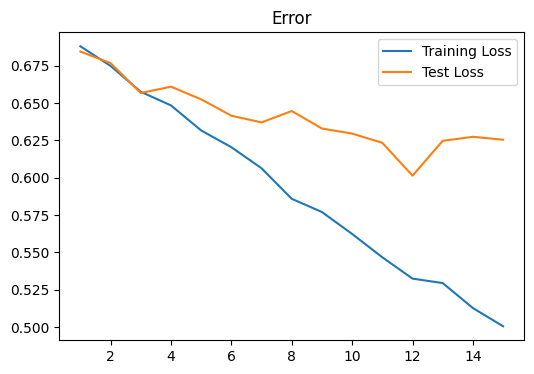

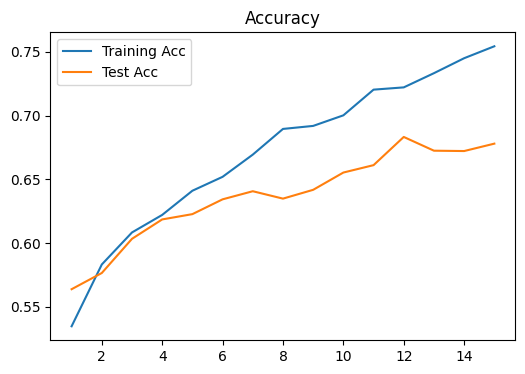

In [13]:
# YOUR CODE HERE
# Error
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(test_loss)+1),test_loss,label='Test Loss')
plt.title("Error")
plt.legend()
plt.show()

# Accuracy
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(train_acc)+1),train_acc, label='Training Acc')
plt.plot(range(1,len(test_acc)+1),test_acc,label='Test Acc')
plt.title("Accuracy")
plt.legend()
plt.show()

2. Comment on line plots.

The model demonstrates rapid overfitting, as indicated by the graphical representations. While the training loss steadily decreases, the validation loss exhibits an upward trend (a clear indicator of overfitting).

Summary of results:

**Training error**: decreases up to epoch 14 and then early stop was triggered.

Train Error:
`Accuracy: 75.4%`, `Avg loss: 0.500501`

**Test error:** was improving until epoch 12, with a score of:

Test Error:
`Accuracy: 67.8%`, `Avg loss: 0.625408`
and then it stopped improving, triggering the early stop.